# 1 Author

**Student Name**: Heng Zhou

**Student ID**:  210985436


# 2 Problem formulation

**Unsupervised Learning for Smile Classification**

Given the scarcity of well-annotated datasets, our primary focus will be on unannotated data, necessitating the use of unsupervised learning. The objective is to categorize images based on whether the subject is smiling. Our goal is to explore outcomes and identify strategies for enhancing performance in this context.

**Semi-Supervised Learning for Smile Detection**

In order to supplement unsupervised learning with some structured guidance, we will engage in semi-supervised learning. This will involve manually annotating data or employing state-of-the-art (SOTA) models for annotation. The aim here is to acquaint ourselves with the semi-supervised learning process and determine how significantly it can boost performance compared to unsupervised learning alone.

**Evaluation Metrics:**

For the classification task (smile detection), we will use F1-Score and Accuracy as our primary evaluation metrics. Higher values in both metrics indicate superior model performance.
For uncovering underlying patterns, our metrics will include the Silhouette Score, Davies-Bouldin Index, and Calinski-Harabasz Index. A Silhouette Score close to 1, a lower Davies-Bouldin Index, and a higher Calinski-Harabasz Index are indicative of better performance.

# 3 Machine Learning pipeline

1. **Load Data:**
   - **Input:** File path.
   - **Output:** An array consisting of all images and their corresponding labels.
2. **Preprocess and Transform Data:**
   - **Input:** Image array.
   - **Process:** The images are first processed and then transformed into a feature matrix using the ResNet50 architecture.
   - **Further Transformation:** Dimensionality reduction is applied to this feature matrix via Principal Component Analysis (PCA).
   - **Output:** A streamlined feature matrix ready for the learning phase.
3. **Unsupervised or Semi-Supervised Learning:**
   - **Input:** Feature matrix.
   - **Process:** Depending on the chosen method, the feature matrix undergoes unsupervised or semi-supervised learning to develop a classifier.
   - **Output:** A classifier capable of making predictions based on the learned patterns.
4. **Evaluate the Results:**
   - After training, the classifier's performance is evaluated using appropriate metrics to ensure its effectiveness and accuracy in real-world scenarios.

# 4 Transformation stage

In image processing, two key aspects are paramount: the arrangement of pixels and their individual values. In my approach, I standardize the pixel values, normalizing them to a range between 0 and 1. This standardization is crucial for ensuring consistent input scales for the model. Additionally, I introduce an element of randomness by selectively omitting some pixels from the images.

This transformation technique serves multiple purposes. Primarily, it significantly enhances the model's effectiveness and robustness. By exposing the model to a variety of data representations, it learns to identify and focus on more generalized features rather than overfitting to specific pixel configurations present in the training set. Moreover, this strategy effectively prevents overfitting, ensuring that the model does not become excessively tailored to the training data, thereby maintaining its ability to perform well on new, unseen data.

The specific steps for implementing these transformations are as follows:

In [1]:
from torchvision.transforms import transforms
from PIL import Image

# Preprocess image to be compatible with the model and improve robustness
def preprocess_image(image):
    if isinstance(image, np.ndarray):
        image = Image.fromarray(image.astype('uint8'))
    # using resize, centercrop and totensor to match the model's input dimensions
    preprocess = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])
    image = preprocess(image).unsqueeze(0)
    return image

Furthermore, advancing in unsupervised or semi-supervised learning necessitates a deep understanding of the dataset's inherent structure. This understanding is crucial as it informs our approach to feature extraction, a vital step in the learning process.

Feature extraction can be approached in several ways, such as utilizing the original pixel values or applying normalization techniques. However, one of the most effective methods is leveraging a pre-trained model. The advantage of using such a model lies in its ability to perform complex tasks without the need for additional fine-tuning. These models have been trained on vast datasets, granting them a robust capacity for feature extraction, surpassing simpler methods that rely solely on raw pixel data.

Here are the details of my implementation approach:

In [2]:
import torch
import numpy as np

# Extract features from a dataset using a model
def feature_extraction(model,dataset):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = model.to(device)
    model.eval()
    all_features = []
    for image, label in dataset:
        image = preprocess_image(image).to(device)
        with torch.no_grad():
            features = model(image)
            features_np = features.squeeze().cpu().numpy()
            all_features.append(features_np)
    all_features_np = np.array(all_features)
    return all_features_np


# 5 Modelling

Furthermore, advancing in unsupervised or semi-supervised learning necessitates a deep understanding of the dataset's inherent structure. This understanding is crucial as it informs our approach to feature extraction, a vital step in the learning process.

Feature extraction can be approached in several ways, such as utilizing the original pixel values or applying normalization techniques. However, one of the most effective methods is leveraging a pre-trained model. The advantage of using such a model lies in its ability to perform complex tasks without the need for additional fine-tuning. These models have been trained on vast datasets, granting them a robust capacity for feature extraction, surpassing simpler methods that rely solely on raw pixel data.

Here are the details of my implementation approach:

In [3]:
import torch.nn as nn
import torch
import torch.nn.functional as F

# The initial CNN used for the experiments
class CNN(nn.Module):
    def __init__(self, num_classes):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(128)
        self.conv4 = nn.Conv2d(128, 256, kernel_size=3, padding=1)
        self.bn4 = nn.BatchNorm2d(256)
        self.fc1 = nn.Linear(256 * 56 * 56, 128) 
        self.dropout = nn.Dropout(0.5)
        self.fc2 = nn.Linear(128, num_classes)

    def forward(self, x):
        x = self.pool(F.leaky_relu(self.bn1(self.conv1(x))))
        x = F.leaky_relu(self.bn2(self.conv2(x)))
        x = self.pool(F.leaky_relu(self.bn3(self.conv3(x))))
        x = F.leaky_relu(self.bn4(self.conv4(x)))
        x = torch.flatten(x, 1)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

In [4]:
from torchvision import models
import torch

# Models used for the experiments
resnet = models.resnet50(pretrained=True)
resnet = torch.nn.Sequential(*(list(resnet.children())[:-1])) 
resnet18 = models.resnet18(pretrained=True)
resnet18 = torch.nn.Sequential(*(list(resnet18.children())[:-1])) 
resnet34 = models.resnet34(pretrained=True)
resnet34 = torch.nn.Sequential(*(list(resnet34.children())[:-1]))
cnn = CNN(2)

/root/miniconda3/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/root/miniconda3/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
/root/miniconda3/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most 

# 6 Methodology

For **Unsupervised Learning:**

Firstly I normalize all features to reduce calculation. Then I use K-means algorithm to make clusters. Finally, I use PCA plot and confusiton matrix along with clasification_report for assession.

The implementation is as follows:


In [5]:
import numpy as np
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report

def flatten_images(X):
    return X.reshape(X.shape[0], -1)

# Cluster the features extracted from the dataset using KMeans
def cluster_features_un(X_train_flat, y_train, X_val_flat, y_val, k=2):
    scaler = StandardScaler()
    features_scaled = scaler.fit_transform(X_train_flat)

    kmeans = KMeans(n_clusters=k, random_state=0)
    clusters = kmeans.fit_predict(features_scaled)
    pca = PCA(n_components=2)
    reduced_features = pca.fit_transform(features_scaled)
    plt.scatter(reduced_features[:, 0], reduced_features[:, 1], c=clusters, cmap='viridis', marker='o')
    plt.xlabel('PCA Feature 1')
    plt.ylabel('PCA Feature 2')
    plt.title('Cluster Visualization')
    plt.show()
    X_val_scaled = scaler.transform(X_val_flat)
    y_val_pred = kmeans.predict(X_val_scaled)
    print(confusion_matrix(y_val, y_val_pred))
    print(classification_report(y_val, y_val_pred))


In [6]:
from sklearn.cluster import DBSCAN
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score
import numpy as np

# Cluster the features extracted from the dataset using DBSCAN
def cluster_with_dbscan(X, eps, min_samples):
    dbscan = DBSCAN(eps=eps, min_samples=min_samples)
    labels = dbscan.fit_predict(X)

    if len(set(labels)) == 1 and labels[0] == -1:
        return -1, -1, -1

    if len(set(labels)) - (1 if -1 in labels else 0) == 1:
        return -1, -1, -1

    # 计算各种评分
    silhouette = silhouette_score(X, labels) if len(set(labels)) > 1 else -1
    davies_bouldin = davies_bouldin_score(X, labels) if silhouette != -1 else -1
    calinski_harabasz = calinski_harabasz_score(X, labels) if silhouette != -1 else -1

    return silhouette, davies_bouldin, calinski_harabasz

# Find the optimal parameters for DBSCAN
def find_optimal_params(X, eps_values, min_samples_values):
    best_score = -1
    best_params = {'eps': None, 'min_samples': None}
    all_scores = []

    for eps in eps_values:
        for min_samples in min_samples_values:
            silhouette, davies_bouldin, calinski_harabasz = cluster_with_dbscan(X, eps, min_samples)
            all_scores.append((eps, min_samples, silhouette, davies_bouldin, calinski_harabasz))

            if silhouette > best_score:
                best_score = silhouette
                best_params = {'eps': eps, 'min_samples': min_samples}

    return best_params, best_score, all_scores


In [7]:
# Cluster the features extracted from the dataset using KMeans
def cluster_with_kmeans(X, n_clusters):
    kmeans = KMeans(n_clusters=n_clusters, random_state=0)
    labels = kmeans.fit_predict(X)

    silhouette = silhouette_score(X, labels)
    davies_bouldin = davies_bouldin_score(X, labels)
    calinski_harabasz = calinski_harabasz_score(X, labels)

    return silhouette, davies_bouldin, calinski_harabasz

# Find the optimal number of clusters for KMeans
def find_optimal_k(X, k_values):
    scores = []
    for k in k_values:
        silhouette, davies_bouldin, calinski_harabasz = cluster_with_kmeans(X, k)
        scores.append((k, silhouette, davies_bouldin, calinski_harabasz))
        print(f"k={k}: Silhouette={silhouette:.2f}, Davies-Bouldin={davies_bouldin:.2f}, Calinski-Harabasz={calinski_harabasz:.2f}")
    return scores


For **Semi-supervised Learning:**

In the initial phase of my approach, I utilize the random library to select a subset of data points that will serve as a reference for the unsupervised learning component. This step is crucial for establishing a baseline understanding of the data's distribution.

Following this, I standardize all the features. Normalization is applied to bring all feature values into a comparable range, effectively reducing computational complexity and enhancing the model's efficiency. This step ensures that variations in scale among different features do not bias the learning process.

Next, I employ the K-means algorithm to partition the data into distinct clusters. This clustering forms the core of the unsupervised learning process, enabling the identification of inherent groupings within the dataset based on feature similarities.

Finally, for the assessment of the model's performance, I utilize two key visualization and evaluation tools: PCA (Principal Component Analysis) plots and confusion matrices. The PCA plot provides a visual representation of the data in reduced dimensions, highlighting the clustering patterns. Meanwhile, the confusion matrix, coupled with a classification report, offers a detailed view of the model's performance, including metrics like precision, recall, and F1-score.

Below are the specific steps and code for my implementation:

In [8]:
from sklearn.cluster import KMeans
import numpy as np
from random import randint
from sklearn.metrics import confusion_matrix, classification_report

# Cluster the features extracted from the dataset using KMeans and use the labels to train a classifier
def cluster_features_semi(X_train, y_train, X_val, y_val, k=2, n=1000):
    cnt = 0
    labeled_indices = []
    while cnt < n:
        idx = randint(0, len(X_train)-1)
        if idx not in labeled_indices:
            labeled_indices.append(idx)
            cnt += 1
            
    scaler = StandardScaler()
    
    features_scaled = scaler.fit_transform(X_train)
            
    labeled_features = X_train[labeled_indices]
    labeled_labels = y_train[labeled_indices]

    unique_labels = np.unique(labeled_labels)
    initial_centers = [labeled_features[labeled_labels == label].mean(axis=0) for label in unique_labels]

    kmeans = KMeans(n_clusters=len(unique_labels), init=np.vstack(initial_centers), n_init=1)
    kmeans.fit(X_train)

    pca = PCA(n_components=k)
    reduced_features = pca.fit_transform(features_scaled)
    
    clusters = kmeans.predict(features_scaled)

    plt.scatter(reduced_features[:, 0], reduced_features[:, 1], c=clusters, cmap='viridis', marker='o')
    plt.xlabel('PCA Feature 1')
    plt.ylabel('PCA Feature 2')
    plt.title('Cluster Visualization')
    plt.show()
    
    y_val_pred = kmeans.predict(X_val)
    print(confusion_matrix(y_val, y_val_pred))
    print(classification_report(y_val, y_val_pred))

# 7 Dataset

At first, I read in the images and labels, making them a dataset.

Then as mentioned above, I did some preprocess, for instance, normalization, dropping pixels, flipping, ratation and so on.

In [11]:
'''
load dataset
'''

import cv2
import os
from sklearn.model_selection import train_test_split

# Load the dataset 
def load_dataset(model):
    os.environ['CUDA_VISIBLE_DEVICES'] = '0'
    root = "files"
    predictors = []

    classification_labels = []
    detection_labels = []
    with open("labels.txt") as f:
        for line in f.readlines():
            classification_labels.append(int(line[0]))
            line = line[2:].split()
            detection_labels.append((float(line[0]), float(line[1]), float(line[2])))
            
    for i in range(len(detection_labels)):
        detection_label = detection_labels[i]
        classification_label = classification_labels[i]
        filename = f'{root}/file{str(i+1).zfill(4)}.jpg'
        img = cv2.imread(filename)
        img = cv2.resize(img, (256, 256))
        predictors.append(img)

    classification_dataset = []
    for i in range(len(classification_labels)):
        classification_dataset.append((predictors[i], classification_labels[i]))
        
    detection_dataset = []
    for i in range(len(detection_labels)):
        detection_dataset.append((predictors[i], detection_labels[i]))

    all_features_np = feature_extraction(model, classification_dataset)
    all_labels = np.array(classification_labels)

    X_train, X_val, y_train, y_val = train_test_split(all_features_np, all_labels, test_size=0.2, random_state=42)
    return X_train, X_val, y_train, y_val

    

# 8 Results

### Classification:

For **Unsupervised Learning:**

We compare the results of the same architecture with different depth and different architecture.


The results of using ResNet50 are as follow:

/root/miniconda3/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


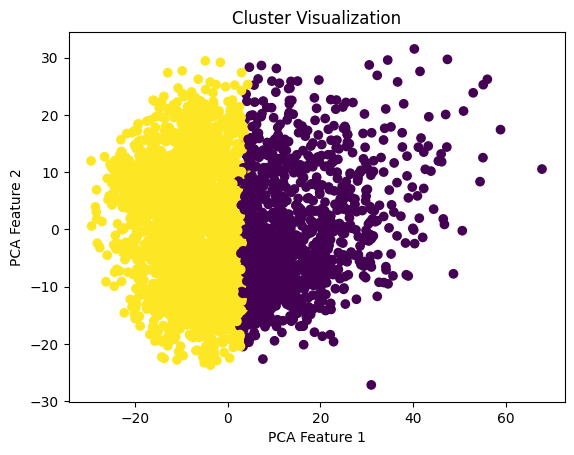

[[150 204]
 [124 322]]
              precision    recall  f1-score   support

           0       0.55      0.42      0.48       354
           1       0.61      0.72      0.66       446

    accuracy                           0.59       800
   macro avg       0.58      0.57      0.57       800
weighted avg       0.58      0.59      0.58       800


In [12]:
X_train, X_val, y_train, y_val = load_dataset(resnet)
X_train_flat = flatten_images(X_train)
X_val_flat = flatten_images(X_val)
cluster_features_un(X_train_flat, y_train, X_val_flat, y_val, k=2)

The results of using ResNet34 are as follow:

/root/miniconda3/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


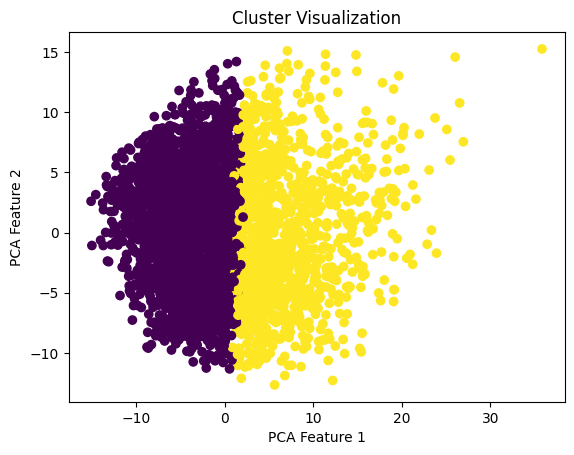

[[187 167]
 [323 123]]
              precision    recall  f1-score   support

           0       0.37      0.53      0.43       354
           1       0.42      0.28      0.33       446

    accuracy                           0.39       800
   macro avg       0.40      0.40      0.38       800
weighted avg       0.40      0.39      0.38       800


In [13]:
X_train, X_val, y_train, y_val = load_dataset(resnet34)
X_train_flat = flatten_images(X_train)
X_val_flat = flatten_images(X_val)
cluster_features_un(X_train_flat, y_train, X_val_flat, y_val, k=2)

The results of using ResNet18 are as follow:

/root/miniconda3/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


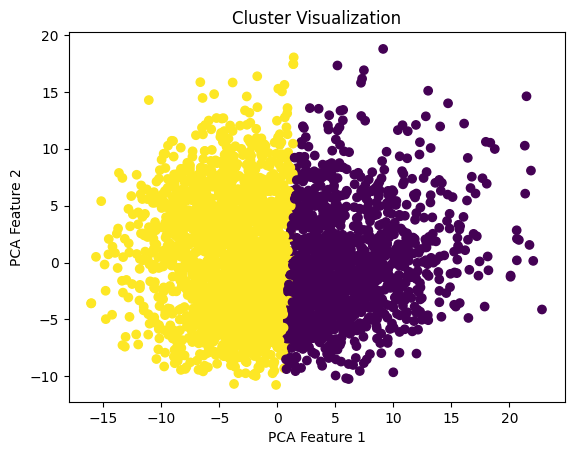

[[177 177]
 [139 307]]
              precision    recall  f1-score   support

           0       0.56      0.50      0.53       354
           1       0.63      0.69      0.66       446

    accuracy                           0.60       800
   macro avg       0.60      0.59      0.59       800
weighted avg       0.60      0.60      0.60       800


In [14]:
X_train, X_val, y_train, y_val = load_dataset(resnet18)
X_train_flat = flatten_images(X_train)
X_val_flat = flatten_images(X_val)
cluster_features_un(X_train_flat, y_train, X_val_flat, y_val, k=2)

The results of using CNN are as follow:

/root/miniconda3/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


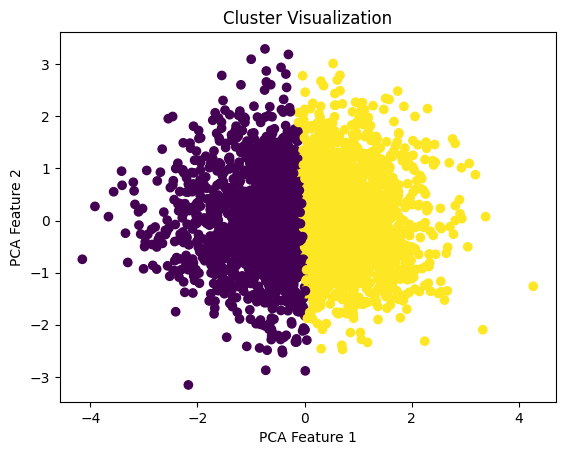

[[146 208]
 [234 212]]
              precision    recall  f1-score   support

           0       0.38      0.41      0.40       354
           1       0.50      0.48      0.49       446

    accuracy                           0.45       800
   macro avg       0.44      0.44      0.44       800
weighted avg       0.45      0.45      0.45       800


In [15]:
X_train, X_val, y_train, y_val = load_dataset(cnn)
X_train_flat = flatten_images(X_train)
X_val_flat = flatten_images(X_val)
cluster_features_un(X_train_flat, y_train, X_val_flat, y_val, k=2)

For **Semi-supervised Learning:**

We compare the performance of the same model with different guidance points and the performance of the same guidance points with different models.

The results of using ResNet18 with *n=200* are as follow:

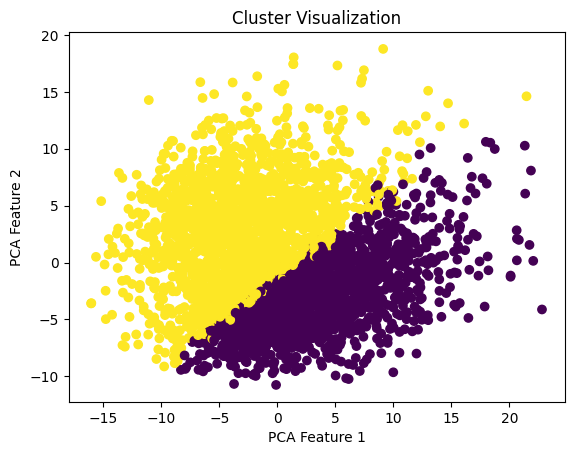

[[265  89]
 [214 232]]
              precision    recall  f1-score   support

           0       0.55      0.75      0.64       354
           1       0.72      0.52      0.60       446

    accuracy                           0.62       800
   macro avg       0.64      0.63      0.62       800
weighted avg       0.65      0.62      0.62       800


In [16]:
X_train, X_val, y_train, y_val = load_dataset(resnet18)
X_train_flat = flatten_images(X_train)
X_val_flat = flatten_images(X_val)
cluster_features_semi(X_train_flat, y_train, X_val_flat, y_val, k=2, n = 200)

The results of using ResNet18 with *n=500* are as follow:

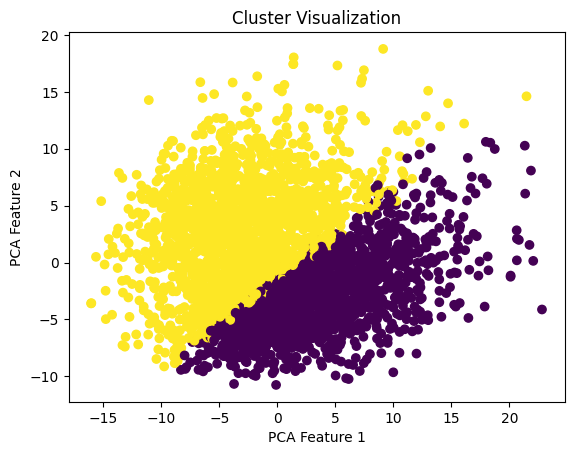

[[264  90]
 [216 230]]
              precision    recall  f1-score   support

           0       0.55      0.75      0.63       354
           1       0.72      0.52      0.60       446

    accuracy                           0.62       800
   macro avg       0.63      0.63      0.62       800
weighted avg       0.64      0.62      0.61       800


In [17]:
X_train, X_val, y_train, y_val = load_dataset(resnet18)
X_train_flat = flatten_images(X_train)
X_val_flat = flatten_images(X_val)
cluster_features_semi(X_train_flat, y_train, X_val_flat, y_val, k=2, n = 500)

The results of using ResNet18 with *n=700* are as follow:

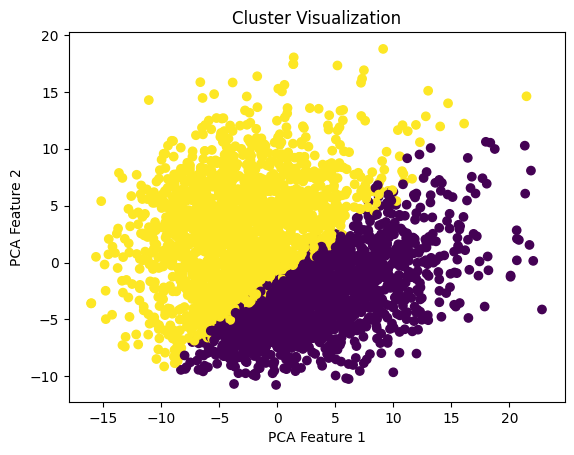

[[264  90]
 [216 230]]
              precision    recall  f1-score   support

           0       0.55      0.75      0.63       354
           1       0.72      0.52      0.60       446

    accuracy                           0.62       800
   macro avg       0.63      0.63      0.62       800
weighted avg       0.64      0.62      0.61       800


In [28]:
X_train, X_val, y_train, y_val = load_dataset(resnet18)
X_train_flat = flatten_images(X_train)
X_val_flat = flatten_images(X_val)
cluster_features_semi(X_train_flat, y_train, X_val_flat, y_val, k=2, n = 700)

The results of using ResNet18 with *n=1000* are as follow:

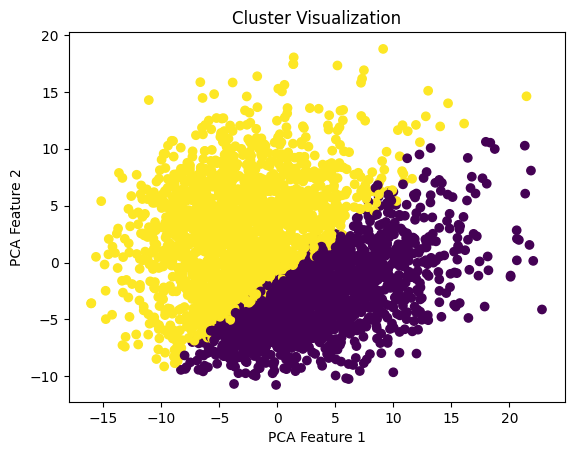

[[264  90]
 [216 230]]
              precision    recall  f1-score   support

           0       0.55      0.75      0.63       354
           1       0.72      0.52      0.60       446

    accuracy                           0.62       800
   macro avg       0.63      0.63      0.62       800
weighted avg       0.64      0.62      0.61       800


In [18]:
X_train, X_val, y_train, y_val = load_dataset(resnet18)
X_train_flat = flatten_images(X_train)
X_val_flat = flatten_images(X_val)
cluster_features_semi(X_train_flat, y_train, X_val_flat, y_val, k=2, n = 1000)

The results of using ResNet50 with *n=200* are as follow:

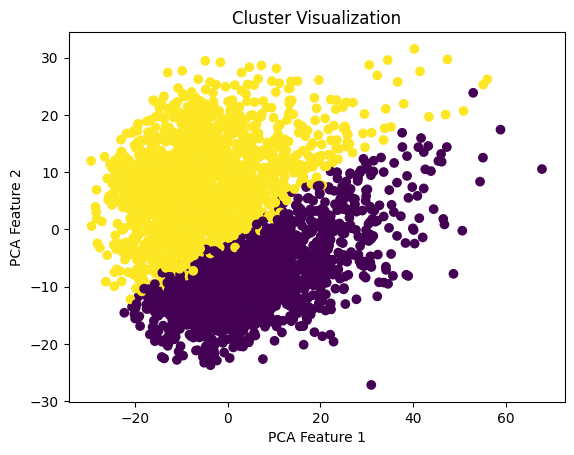

[[260  94]
 [196 250]]
              precision    recall  f1-score   support

           0       0.57      0.73      0.64       354
           1       0.73      0.56      0.63       446

    accuracy                           0.64       800
   macro avg       0.65      0.65      0.64       800
weighted avg       0.66      0.64      0.64       800


In [19]:
X_train, X_val, y_train, y_val = load_dataset(resnet)
X_train_flat = flatten_images(X_train)
X_val_flat = flatten_images(X_val)
cluster_features_semi(X_train_flat, y_train, X_val_flat, y_val, k=2, n = 200)

The results of using ResNet50 with *n=500* are as follow:

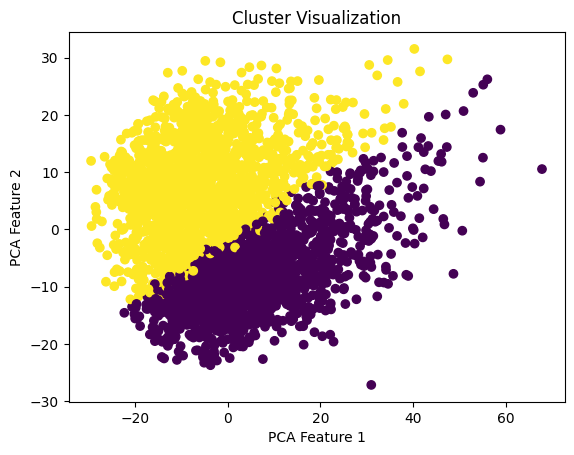

[[262  92]
 [197 249]]
              precision    recall  f1-score   support

           0       0.57      0.74      0.64       354
           1       0.73      0.56      0.63       446

    accuracy                           0.64       800
   macro avg       0.65      0.65      0.64       800
weighted avg       0.66      0.64      0.64       800


In [20]:
X_train, X_val, y_train, y_val = load_dataset(resnet)
X_train_flat = flatten_images(X_train)
X_val_flat = flatten_images(X_val)
cluster_features_semi(X_train_flat, y_train, X_val_flat, y_val, k=2, n = 500)

The results of using ResNet50 with n=700 are as follow:

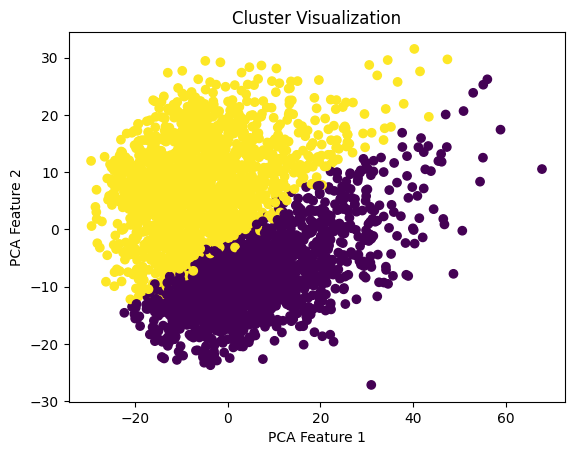

[[261  93]
 [197 249]]
              precision    recall  f1-score   support

           0       0.57      0.74      0.64       354
           1       0.73      0.56      0.63       446

    accuracy                           0.64       800
   macro avg       0.65      0.65      0.64       800
weighted avg       0.66      0.64      0.64       800


In [29]:
X_train, X_val, y_train, y_val = load_dataset(resnet)
X_train_flat = flatten_images(X_train)
X_val_flat = flatten_images(X_val)
cluster_features_semi(X_train_flat, y_train, X_val_flat, y_val, k=2, n = 700)

The results of using ResNet50 with *n=1000* are as follow:

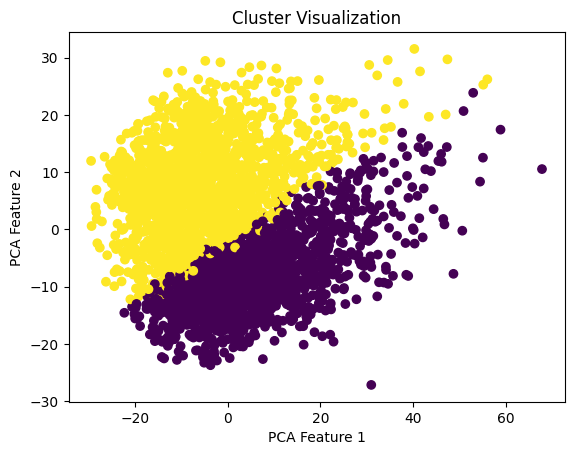

[[261  93]
 [196 250]]
              precision    recall  f1-score   support

           0       0.57      0.74      0.64       354
           1       0.73      0.56      0.63       446

    accuracy                           0.64       800
   macro avg       0.65      0.65      0.64       800
weighted avg       0.66      0.64      0.64       800


In [21]:
X_train, X_val, y_train, y_val = load_dataset(resnet)
X_train_flat = flatten_images(X_train)
X_val_flat = flatten_images(X_val)
cluster_features_semi(X_train_flat, y_train, X_val_flat, y_val, k=2, n = 1000)

The results of using cnn with n = 200 are as follow:

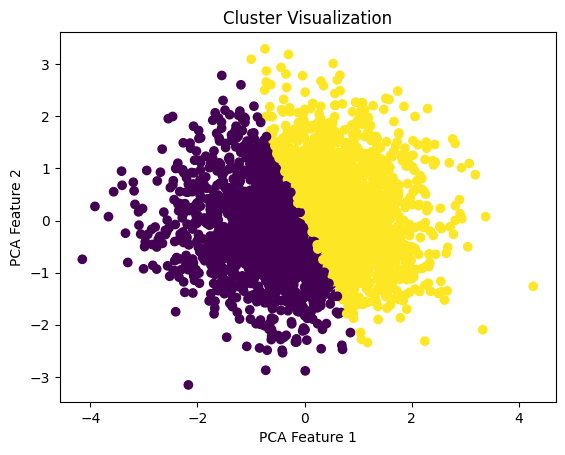

[[145 209]
 [222 224]]
              precision    recall  f1-score   support

           0       0.40      0.41      0.40       354
           1       0.52      0.50      0.51       446

    accuracy                           0.46       800
   macro avg       0.46      0.46      0.46       800
weighted avg       0.46      0.46      0.46       800


In [22]:
X_train, X_val, y_train, y_val = load_dataset(cnn)
X_train_flat = flatten_images(X_train)
X_val_flat = flatten_images(X_val)
cluster_features_semi(X_train_flat, y_train, X_val_flat, y_val, k=2, n = 200)

The results of using cnn with n = 500 are as follow:

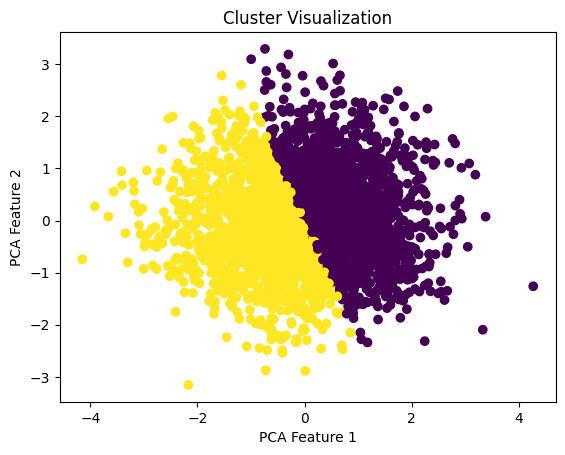

[[208 146]
 [224 222]]
              precision    recall  f1-score   support

           0       0.48      0.59      0.53       354
           1       0.60      0.50      0.55       446

    accuracy                           0.54       800
   macro avg       0.54      0.54      0.54       800
weighted avg       0.55      0.54      0.54       800


In [23]:
X_train, X_val, y_train, y_val = load_dataset(cnn)
X_train_flat = flatten_images(X_train)
X_val_flat = flatten_images(X_val)
cluster_features_semi(X_train_flat, y_train, X_val_flat, y_val, k=2, n = 500)

The results of using cnn with n = 700 are as follow:

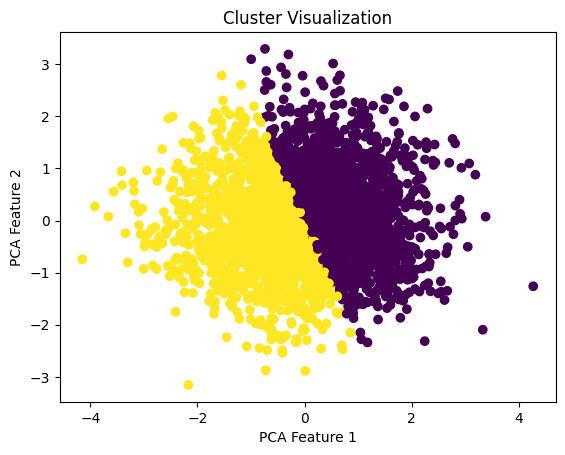

[[208 146]
 [224 222]]
              precision    recall  f1-score   support

           0       0.48      0.59      0.53       354
           1       0.60      0.50      0.55       446

    accuracy                           0.54       800
   macro avg       0.54      0.54      0.54       800
weighted avg       0.55      0.54      0.54       800


In [30]:
X_train, X_val, y_train, y_val = load_dataset(cnn)
X_train_flat = flatten_images(X_train)
X_val_flat = flatten_images(X_val)
cluster_features_semi(X_train_flat, y_train, X_val_flat, y_val, k=2, n = 700)

The results of using cnn with n = 1000 are as follow:

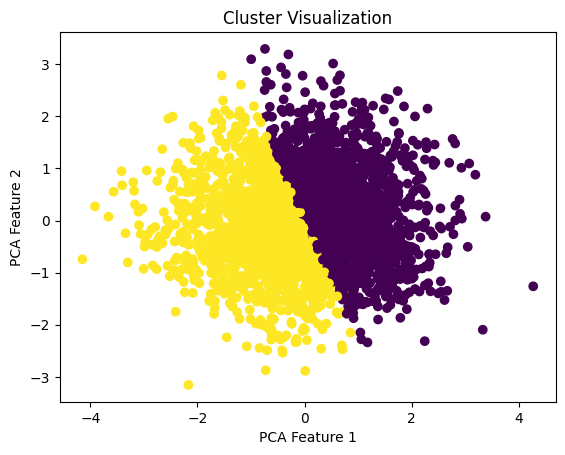

[[208 146]
 [224 222]]
              precision    recall  f1-score   support

           0       0.48      0.59      0.53       354
           1       0.60      0.50      0.55       446

    accuracy                           0.54       800
   macro avg       0.54      0.54      0.54       800
weighted avg       0.55      0.54      0.54       800


In [24]:
X_train, X_val, y_train, y_val = load_dataset(cnn)
X_train_flat = flatten_images(X_train)
X_val_flat = flatten_images(X_val)
cluster_features_semi(X_train_flat, y_train, X_val_flat, y_val, k=2, n = 1000)

**Unsupervised Learning Outcomes:**

In the realm of unsupervised learning, I observed that ResNet18 outperforms the others, delivering the highest level of performance. Following closely is ResNet50, which also shows commendable results. Surprisingly, the performance of ResNet34 falls short, being surpassed even by a simpler CNN model. This unexpected outcome suggests that increased network complexity in ResNet34 does not necessarily translate to better feature extraction capabilities in an unsupervised learning context.

**Semi-Supervised Learning Insights:**

Turning to semi-supervised learning, a notable improvement in performance is evident across all classifiers when compared to their unsupervised counterparts. This underscores the value of providing even a limited amount of labeled data to guide the learning process. However, an interesting observation arises when increasing the number of guidance points: the performance enhancement is not as significant as anticipated. This plateau suggests that beyond a certain point, simply adding more semi-supervised data does not contribute substantially to further learning gains.


# 9 Conclusions

### Conclusions:

1. **Superiority of Pretrained Models:** Compared to simpler networks, pretrained models demonstrate enhanced feature extraction capabilities, attributable to their sophisticatedly trained parameters acquired during the pre-training phase.
2. **Depth versus Performance in Simple Tasks:** In straightforward binary classification tasks, increasing a neural network's depth doesn't necessarily boost performance. On the contrary, it might lead to performance decline due to overfitting and model degradation.
3. **Advantage of Semi-Supervised Learning:** Semi-supervised classifiers consistently outperform their unsupervised counterparts. This superiority stems from having predefined cluster centers right from the start.
4. **Impact of Increasing Semi-Supervised Points:** Adding more semi-supervised data points tends not to diminish classifier accuracy. However, it's not always clear if this expansion will lead to notable performance enhancements.
5. **Supervised versus Unsupervised Learning:** Both unsupervised and semi-supervised learning methods fall short of the effectiveness of supervised learning, aligning with conventional expectations.
6. **Limitations in Unsupervised Learning:** Certain unsupervised learning models even underperform compared to random guessing. This suggests that the dataset possesses a more intricate structure beyond a simple binary distribution.

### Improvements:

1. **ResNet as a Feature Extractor:** Employing ResNet for feature extraction has shown to yield better results than models without pre-training.
2. **Comparative Performance Analysis:** Evaluating the effectiveness of semi-supervised and unsupervised learning in contrast with supervised learning.

### Future Work:

1. **Exploring Stronger Models for Feature Extraction:** Investigating more advanced models to enhance the feature extraction process.
2. **Quality-Driven Semi-Supervised Learning:** Selecting high-quality data points manually for semi-supervised learning to assess the relationship between data quality and the performance of semi-supervised learning models.